In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# nvcc version 확인
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0


In [ ]:
!nvidia-smi

Wed Mar 27 00:37:41 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 12.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   29C    P0    62W / 400W |  12973MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:90:00.0 Off |                    0 |
| N/A   

In [ ]:
# 필수 Package import
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

[1711467464.719718] [air-research-0:1814338:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print('Device:', device)
print('Count of using GPUs:', torch.cuda.device_count())
print('Current cuda device:', torch.cuda.current_device())

Device: cuda
Count of using GPUs: 1
Current cuda device: 0


In [ ]:
# 이미지를 출력하는 함수
def display_images(image_paths, title, max_images=4):
    """지정된 경로의 이미지를 최대 4개까지 출력합니다."""
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

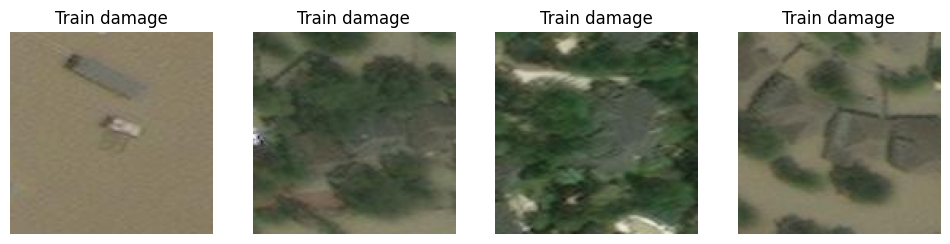

Train damage 총 이미지 수: 5900


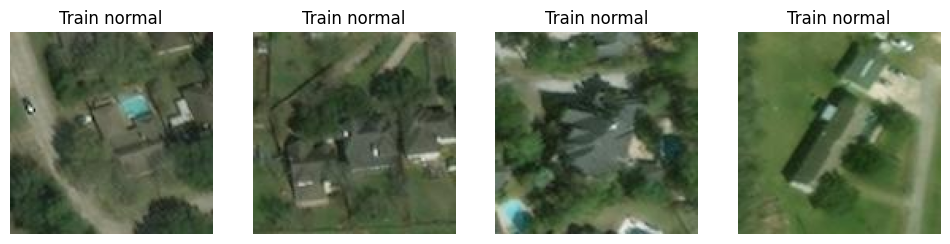

Train normal 총 이미지 수: 5900


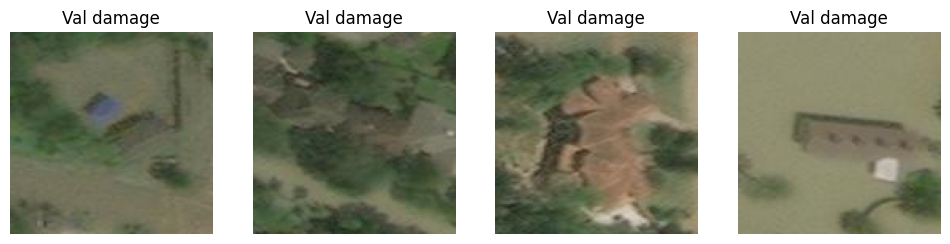

Val damage 총 이미지 수: 1000


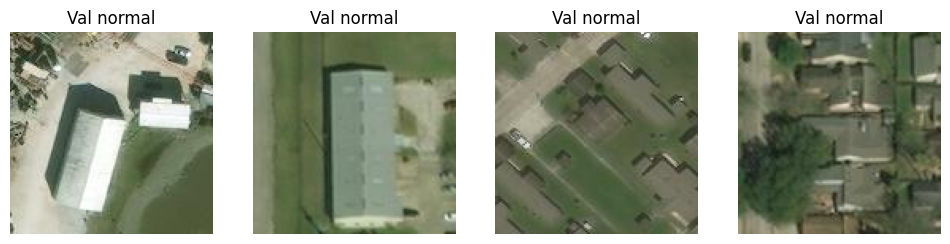

Val normal 총 이미지 수: 1000


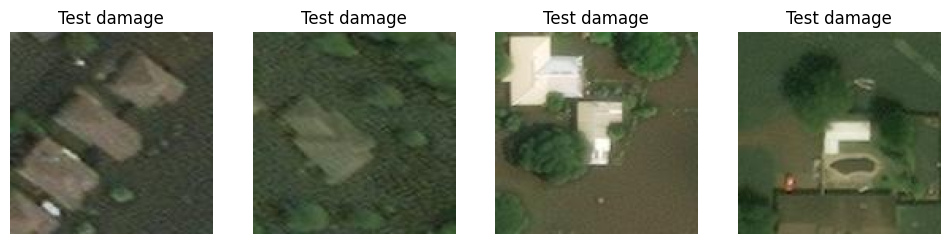

Test damage 총 이미지 수: 100


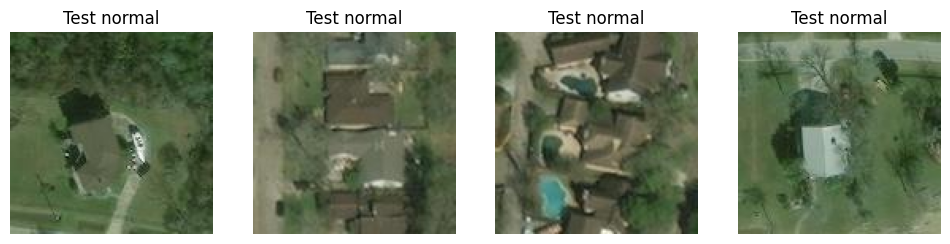

Test normal 총 이미지 수: 100


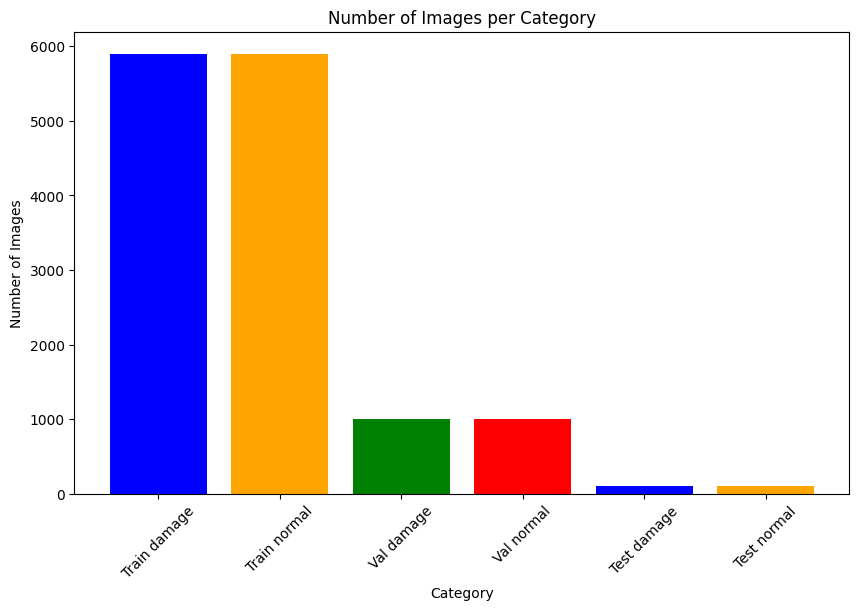

In [ ]:
# 이미지와 바 그래프 출력
categories = ['Train damage', 'Train normal', 'Val damage', 'Val normal', 'Test damage', 'Test normal']


for category in categories:
    image_paths = glob.glob(f'/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/9/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
    print(f"{category} 총 이미지 수: {len(image_paths)}")

# 바 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/9/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from imgaug import augmenters as iaa
import imgaug as ia

# imgaug를 사용한 커스텀 데이터셋 정의
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.LinearContrast((0.75, 1.5)),  # 대비 조절
            iaa.Fliplr(0.5),  # 50% 확률로 좌우 반전
            iaa.Flipud(0.2),  # 20% 확률로 상하 반전
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

In [ ]:
# 커스텀 데이터셋 클래스
class CustomDataset(ImageFolder):
    def __init__(self, root, imgaug=None, transform=None, sample_per_class=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug  # imgaug 매개변수를 직접 저장

        if sample_per_class is not None:
            self.samples = self._reduce_samples(sample_per_class)

    def _reduce_samples(self, sample_per_class):
        class_samples = {}
        for path, target in self.samples:
            if target not in class_samples:
                class_samples[target] = [path]
            else:
                class_samples[target].append(path)

        reduced_samples = []
        for target, paths in class_samples.items():
            if len(paths) > sample_per_class:
                reduced_samples.extend([(path, target) for path in random.sample(paths, sample_per_class)])
            else:
                reduced_samples.extend([(path, target) for path in paths])


        return reduced_samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        # imgaug 증강 적용
        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            # imgaug는 numpy 배열을 반환하므로, PIL Image로 다시 변환
            img = Image.fromarray(img)

        # ToTensor 및 Normalize 적용
        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [ ]:
# PyTorch transforms에서 ToTensor 및 Normalize만 적용
from torchvision import transforms

pytorch_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# 데이터셋 및 데이터 로더 초기화
train_path = '/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/9/train'
val_path = '/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/9/val'

train_dataset = CustomDataset(train_path, imgaug=ImgAugTransform(), transform=pytorch_transforms)
val_dataset = CustomDataset(val_path, imgaug=None, transform=pytorch_transforms, sample_per_class=128)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# DataLoader에서 샘플을 이미지를 load해 show하는 함수
def imshow(img, size=(20, 20), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean  # 역정규화
    img = np.clip(img, 0, 1)  # 값이 0과 1 사이에 오도록 클리핑
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

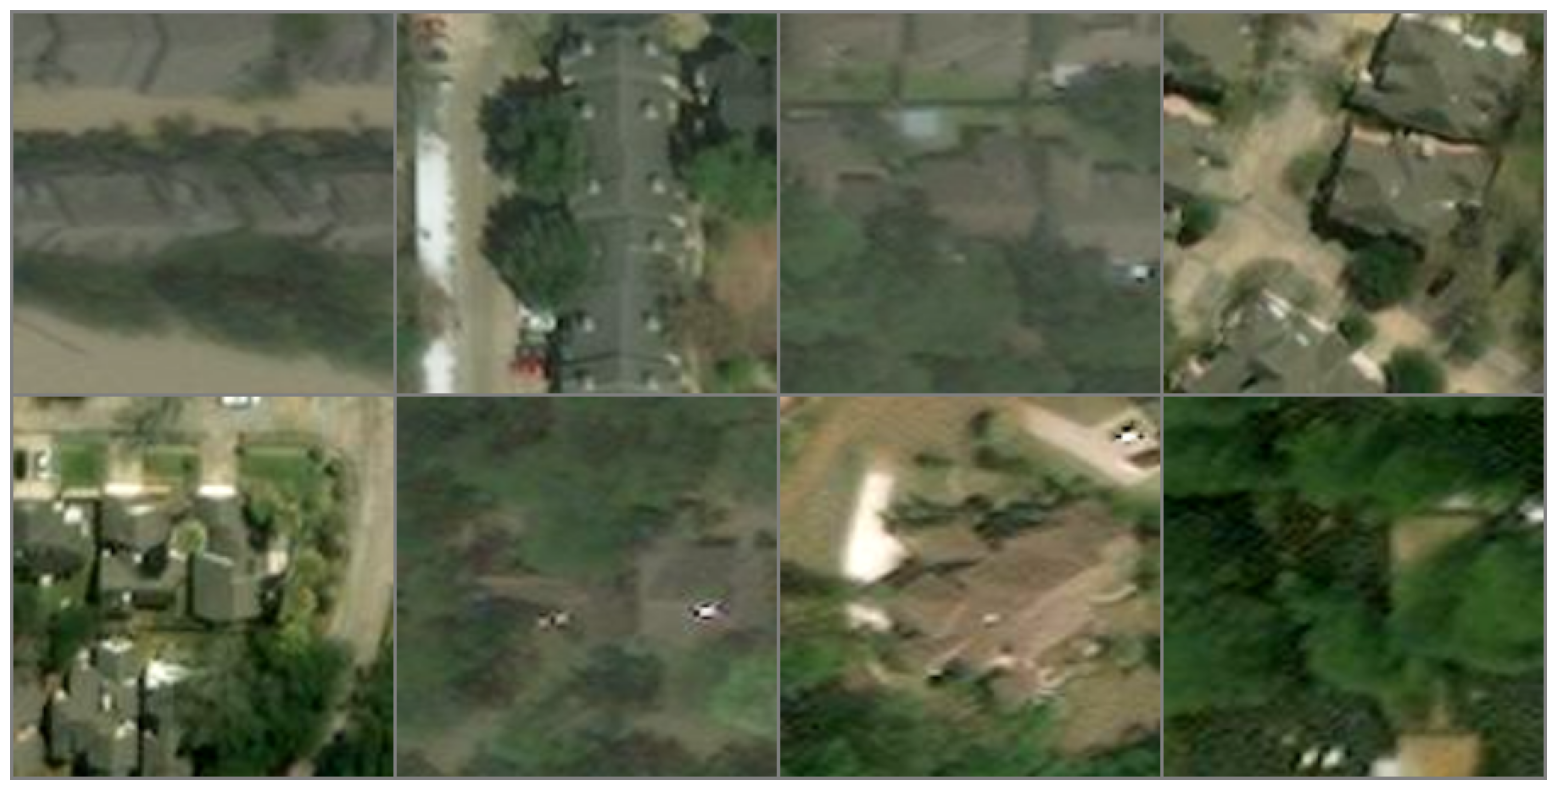

In [ ]:
# DataLoader를 이용하여 배치 데이터 가져오기
dataiter = iter(train_loader)
images, _ = next(dataiter)

# 이미지 그리드 생성 및 시각화, nrow를 조정하여 한 줄에 표시되는 이미지의 수 조정
imshow(make_grid(images[:8], nrow=4), size=(20, 10))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

class densenet169(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 32, 32),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000):

        super(densenet169, self).__init__()
        # Initial convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [ ]:
# 사전 학습된 densenet169 모델 불러오기
pretrained_densenet169 = models.densenet169(pretrained=True)
# 새로 정의한 모델 인스턴스 생성
net = densenet169(num_classes=1000)


# 사전 학습된 모델의 features 부분에서 가중치 추출
pretrained_keys = set(pretrained_densenet169.state_dict().keys())
# 사전 학습된 모델에서 커스텀 모델로 가중치 복사 시도
result = net.load_state_dict(pretrained_densenet169.state_dict(), strict=False)
# 복사 후 커스텀 모델의 features 부분에서 가중치 추출
custom_keys = set(net.state_dict().keys())


# 성공적으로 복사된 가중치 (커스텀 모델과 사전 학습된 모델 모두에 존재)
successfully_copied_keys = pretrained_keys.intersection(custom_keys)
# 커스텀 모델에 있지만 사전 학습된 모델에 없는 가중치
missing_keys = custom_keys - pretrained_keys
# 사전 학습된 모델에 있지만 커스텀 모델에 없는 가중치
unexpected_keys = pretrained_keys - custom_keys

print("성공적으로 복사된 가중치:", successfully_copied_keys)
print("커스텀 모델에는 있지만 사전 학습된 모델에는 없는 가중치 (누락):", result.missing_keys)
print("사전 학습된 모델에는 있지만 커스텀 모델에는 없는 가중치 (예상치 못한):", result.unexpected_keys) # net 모델에 없는데 pretrained_vgg19 가중치 파일에는 존재하는 항목의 이름이 리스트로 반환

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


성공적으로 복사된 가중치: {'features.denseblock2.denselayer6.norm2.weight', 'features.denseblock3.denselayer22.norm2.num_batches_tracked', 'features.denseblock3.denselayer11.norm2.weight', 'features.denseblock3.denselayer6.norm2.bias', 'features.denseblock3.denselayer17.norm2.num_batches_tracked', 'features.denseblock2.denselayer4.norm1.bias', 'features.denseblock3.denselayer16.norm2.running_mean', 'features.denseblock3.denselayer22.norm2.running_mean', 'features.denseblock3.denselayer23.norm2.weight', 'features.denseblock3.denselayer27.norm2.running_mean', 'features.denseblock2.denselayer8.norm1.num_batches_tracked', 'features.denseblock4.denselayer31.norm2.running_mean', 'features.denseblock1.denselayer2.norm1.weight', 'features.denseblock3.denselayer17.norm1.num_batches_tracked', 'features.denseblock4.denselayer21.norm2.bias', 'features.denseblock4.denselayer4.conv2.weight', 'features.denseblock2.denselayer9.norm1.running_var', 'features.denseblock3.denselayer20.norm1.running_var', 'features.d

In [ ]:
print(net)

densenet169(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (r

In [ ]:
# 모델의 모든 파라미터를 고정
for param in net.parameters():
    param.requires_grad = False

In [ ]:
# classifier 부분의 가중치는 재학습을 위해 새로 정의
net.classifier = nn.Linear(1664, 1)

for param in net.classifier.parameters():
    param.requires_grad = True

net = net.to(device)

In [ ]:
# 손실 함수
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def validate_model(net, val_loader, criterion):
    net.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            outputs = net(inputs)
            val_loss += criterion(outputs, labels).item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [ ]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    # optimizer 설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.00003, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0

        # tqdm을 사용하여 진행 상황 표시
        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 및 정확도 계산
        val_loss, val_accuracy = validate_model(net, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # 에폭 종료 후 로그 출력
        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [ ]:
train_losses_RAdam, val_losses_RAdam, val_accuracies_RAdam = train_model('RAdam', net, train_loader, val_loader, criterion)

Epoch 1/20: 100%|██████████| 369/369 [00:51<00:00,  7.22it/s]


[RAdam] Epoch 1, Train Loss: 0.661703, Val Loss: 0.631466, Validation Accuracy: 71.09%


Epoch 2/20: 100%|██████████| 369/369 [00:48<00:00,  7.54it/s]


[RAdam] Epoch 2, Train Loss: 0.610056, Val Loss: 0.572532, Validation Accuracy: 82.03%


Epoch 3/20: 100%|██████████| 369/369 [00:49<00:00,  7.49it/s]


[RAdam] Epoch 3, Train Loss: 0.556669, Val Loss: 0.513216, Validation Accuracy: 87.50%


Epoch 4/20: 100%|██████████| 369/369 [00:46<00:00,  8.00it/s]


[RAdam] Epoch 4, Train Loss: 0.503859, Val Loss: 0.455278, Validation Accuracy: 90.62%


Epoch 5/20: 100%|██████████| 369/369 [00:44<00:00,  8.28it/s]


[RAdam] Epoch 5, Train Loss: 0.458849, Val Loss: 0.412398, Validation Accuracy: 91.80%


Epoch 6/20: 100%|██████████| 369/369 [00:44<00:00,  8.20it/s]


[RAdam] Epoch 6, Train Loss: 0.421363, Val Loss: 0.374277, Validation Accuracy: 91.41%


Epoch 7/20: 100%|██████████| 369/369 [00:45<00:00,  8.16it/s]


[RAdam] Epoch 7, Train Loss: 0.395870, Val Loss: 0.340545, Validation Accuracy: 92.19%


Epoch 8/20: 100%|██████████| 369/369 [00:43<00:00,  8.50it/s]


[RAdam] Epoch 8, Train Loss: 0.366278, Val Loss: 0.316629, Validation Accuracy: 91.02%


Epoch 9/20: 100%|██████████| 369/369 [00:45<00:00,  8.16it/s]


[RAdam] Epoch 9, Train Loss: 0.348094, Val Loss: 0.293970, Validation Accuracy: 92.19%


Epoch 10/20: 100%|██████████| 369/369 [00:46<00:00,  7.85it/s]


[RAdam] Epoch 10, Train Loss: 0.329989, Val Loss: 0.276692, Validation Accuracy: 93.75%


Epoch 11/20: 100%|██████████| 369/369 [00:48<00:00,  7.62it/s]


[RAdam] Epoch 11, Train Loss: 0.313703, Val Loss: 0.262587, Validation Accuracy: 92.58%


Epoch 12/20: 100%|██████████| 369/369 [00:44<00:00,  8.23it/s]


[RAdam] Epoch 12, Train Loss: 0.300971, Val Loss: 0.248559, Validation Accuracy: 93.75%


Epoch 13/20: 100%|██████████| 369/369 [00:47<00:00,  7.80it/s]


[RAdam] Epoch 13, Train Loss: 0.290747, Val Loss: 0.236039, Validation Accuracy: 92.58%


Epoch 14/20: 100%|██████████| 369/369 [00:43<00:00,  8.42it/s]


[RAdam] Epoch 14, Train Loss: 0.278351, Val Loss: 0.227472, Validation Accuracy: 93.36%


Epoch 15/20: 100%|██████████| 369/369 [00:45<00:00,  8.03it/s]


[RAdam] Epoch 15, Train Loss: 0.272873, Val Loss: 0.219178, Validation Accuracy: 93.75%


Epoch 16/20: 100%|██████████| 369/369 [00:46<00:00,  7.89it/s]


[RAdam] Epoch 16, Train Loss: 0.266479, Val Loss: 0.211888, Validation Accuracy: 93.36%


Epoch 17/20: 100%|██████████| 369/369 [00:48<00:00,  7.59it/s]


[RAdam] Epoch 17, Train Loss: 0.258450, Val Loss: 0.202963, Validation Accuracy: 93.36%


Epoch 18/20: 100%|██████████| 369/369 [00:45<00:00,  8.05it/s]


[RAdam] Epoch 18, Train Loss: 0.247752, Val Loss: 0.197546, Validation Accuracy: 94.53%


Epoch 19/20: 100%|██████████| 369/369 [00:45<00:00,  8.13it/s]


[RAdam] Epoch 19, Train Loss: 0.243886, Val Loss: 0.193762, Validation Accuracy: 93.36%


Epoch 20/20: 100%|██████████| 369/369 [00:44<00:00,  8.30it/s]


[RAdam] Epoch 20, Train Loss: 0.241499, Val Loss: 0.188062, Validation Accuracy: 94.53%


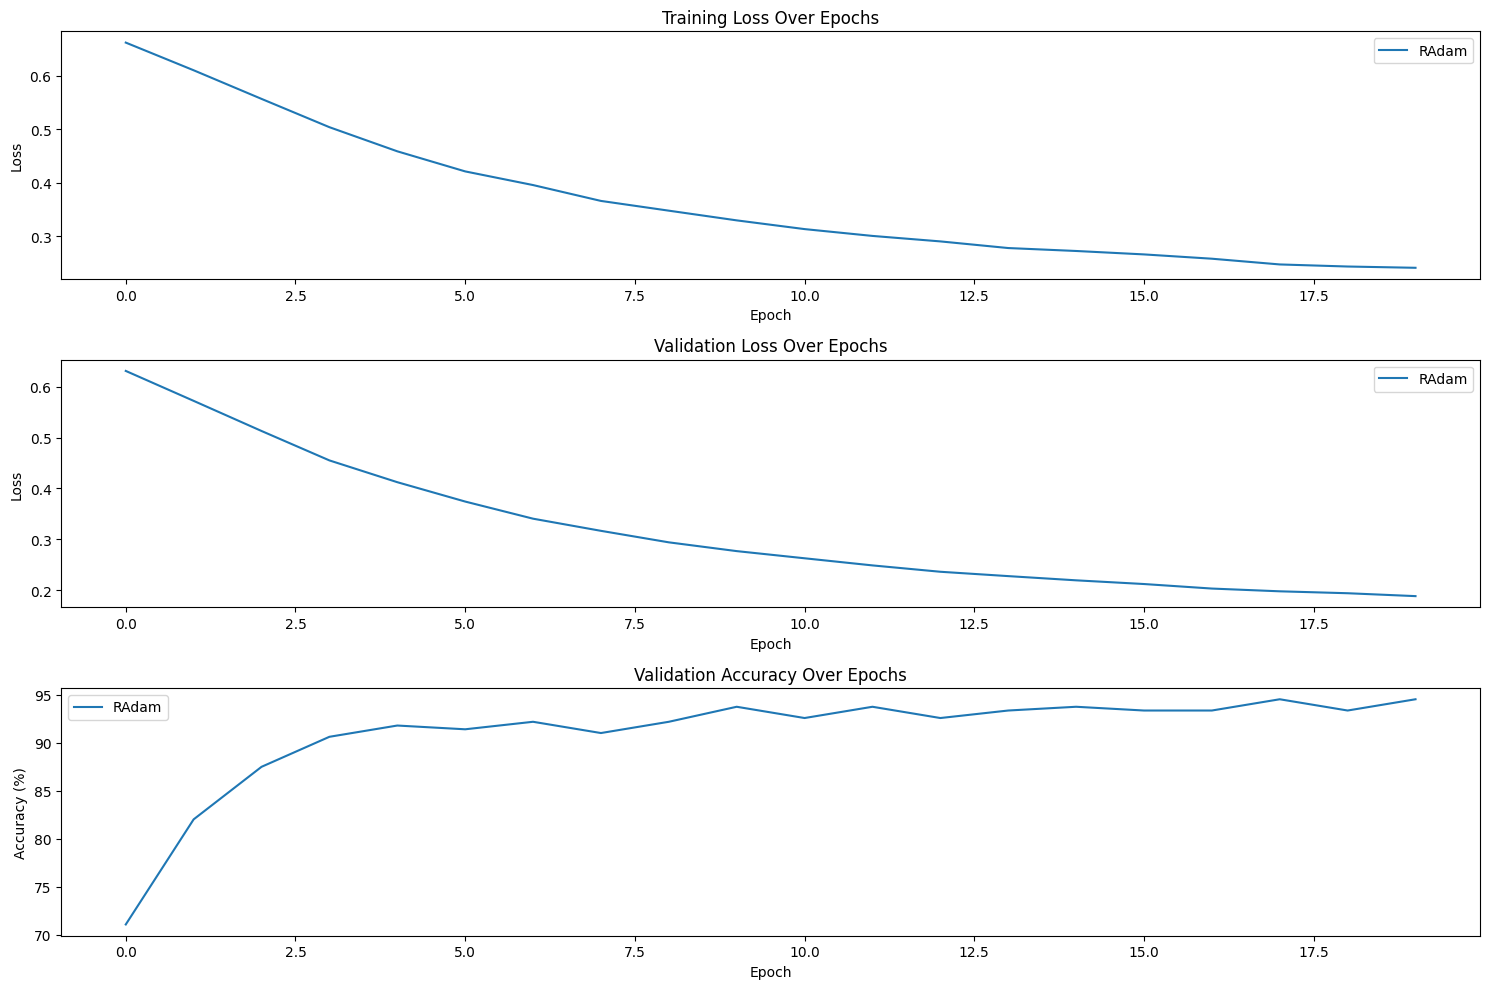

In [ ]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

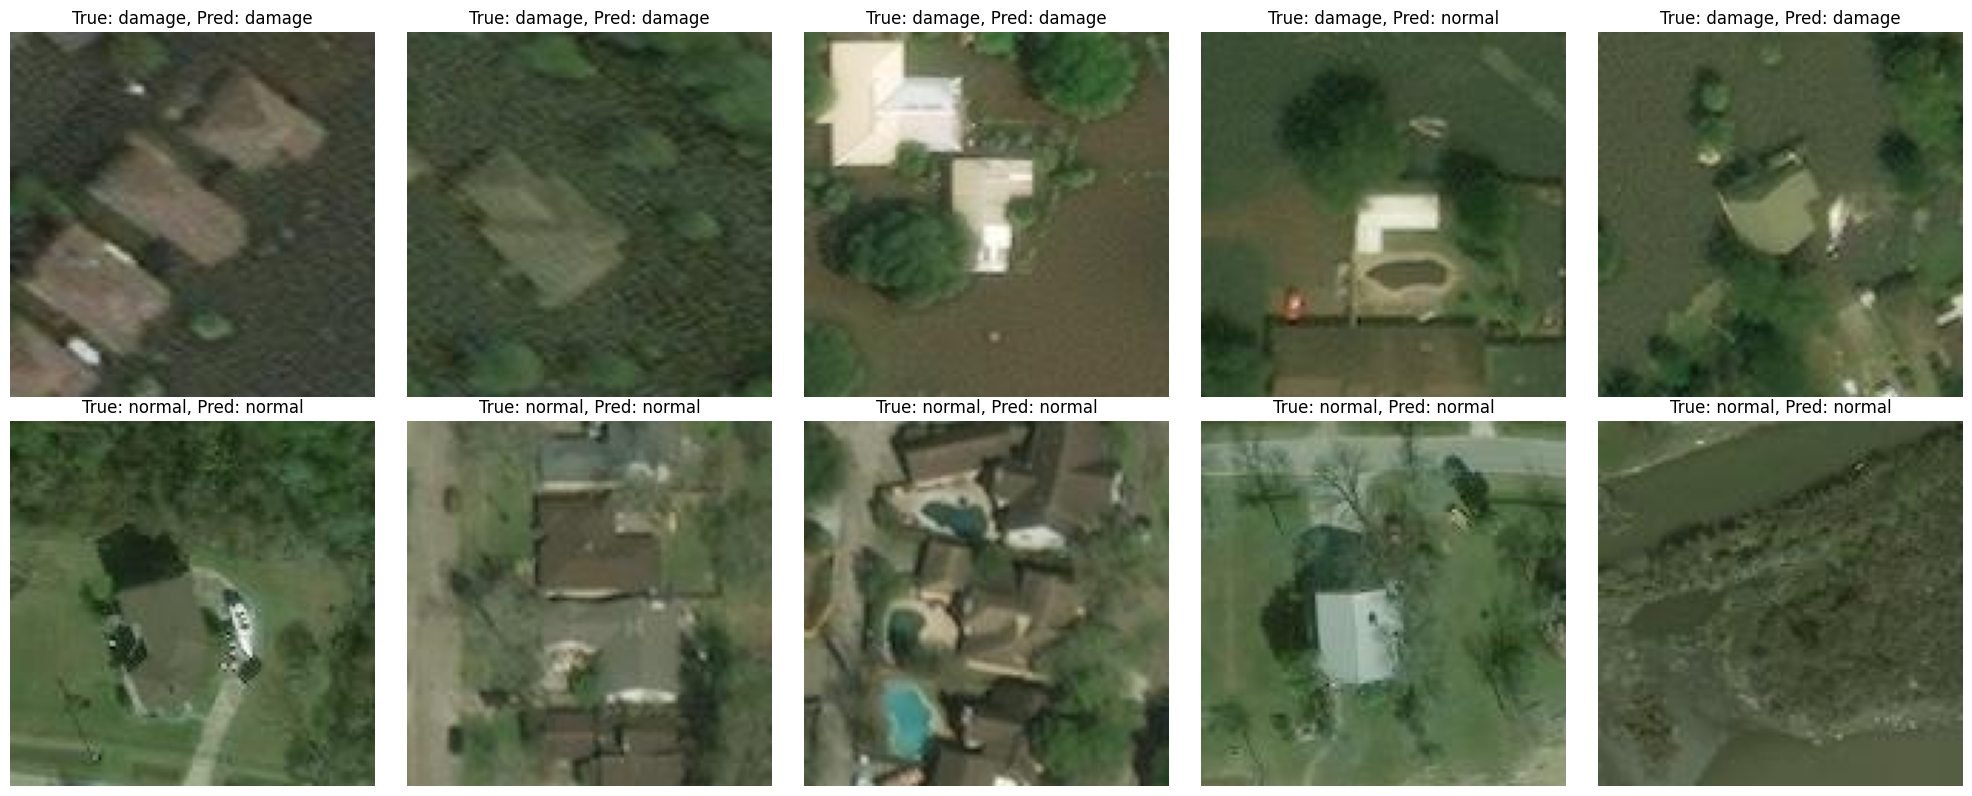

In [ ]:
class_folders = {
    'damage': '/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/9/test/damage',
    'normal': '/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/9/test/normal'
}

plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transforms)

        net.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = net(image)
            # 시그모이드 함수 적용하여 확률 얻기
            probs = torch.sigmoid(outputs).item()
            prediction = 'normal' if probs >= 0.5 else 'damage'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, class_folders, transform):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    for class_name, folder_path in class_folders.items():
        image_paths = glob.glob(os.path.join(folder_path, '*'))

        for image_path in image_paths:
            image = load_and_transform_image(image_path, transform)

            with torch.no_grad():
                outputs = model(image)
                probs = torch.sigmoid(outputs).item()
                prediction = 1 if probs >= 0.5 else 0
                all_preds.append(prediction)
                all_labels.append(1 if class_name == 'normal' else 0)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, precision, recall, f1

In [ ]:
# Evaluate models
densenet_metrics = evaluate_model(net, class_folders, pytorch_transforms)

# Print comparison
print("densenet Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*densenet_metrics))

densenet Metrics: Accuracy: 0.9650, Precision: 0.9604, Recall: 0.9700, F1: 0.9652
